# Лабораторная работа №10 Линейные стационарные системы

Кобыжев Александр, группа 3530901/80202

### Упражнение 10.1

In [1]:
from __future__ import print_function, division

import thinkdsp
import thinkplot

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

PI2 = 2 * np.pi

np.set_printoptions(precision=3, suppress=True)
%matplotlib inline

Усечём оба сигнала до $2^{16}$ элементов, а затем обнуляем их до $2^{17}$. Использование степени двойки делает алгоритм ДПФ наиболее эффективным.

Вот импульсный отклик:

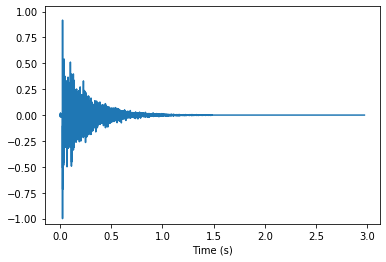

In [30]:
response = thinkdsp.read_wave('180960__kleeb__gunshot.wav')

start = 0.12
response = response.segment(start=start)
response.shift(-start)

response.truncate(2**16)
response.zero_pad(2**17)

response.normalize()
response.plot()
thinkplot.config(xlabel='Time (s)', ylim=[-1.05, 1.05])

А теперь составим спектр:

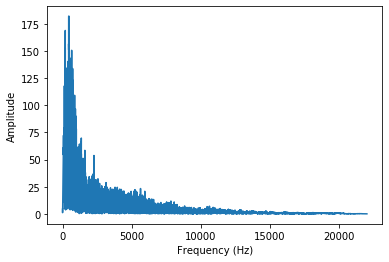

In [31]:
transfer = response.make_spectrum()
transfer.plot()
thinkplot.config(xlabel='Frequency (Hz)', ylabel='Amplitude')

Рассмотрим другой сигнал.

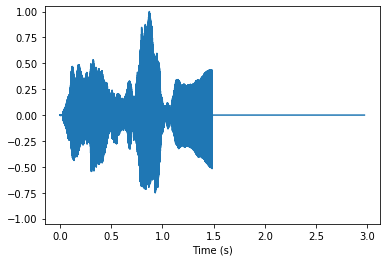

In [32]:
violin = thinkdsp.read_wave('92002__jcveliz__violin-origional.wav')

start = 0.11
violin = violin.segment(start=start)
violin.shift(-start)

violin.truncate(2**16)
violin.zero_pad(2**17)

violin.normalize()
violin.plot()
thinkplot.config(xlabel='Time (s)', ylim=[-1.05, 1.05])

Составим спектр:

In [33]:
spectrum = violin.make_spectrum()

Теперь умножим ДПФ сигнала на передаточную функцию и преобразуем обратно в волну:

In [34]:
output = (spectrum * transfer).make_wave()
output.normalize()

Визуализируем полученный сигнал.

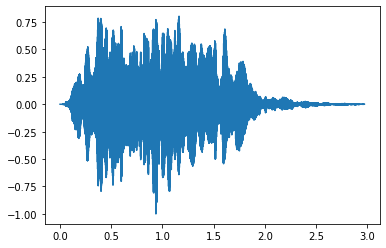

In [35]:
output.plot()

Результат не выглядит так, как будто он оборачивается вокруг:

In [36]:
output.make_audio()

Лишнюю ноту в начале не слышно. Мы должны получить такие же результаты от `np.convolve` и `scipy.signal.fftconvolve`.

Сначала избавимся от нулевого отступа:

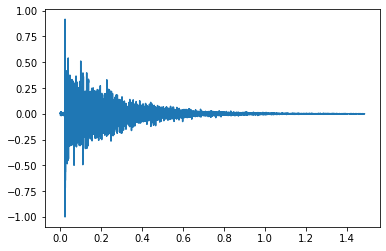

In [37]:
response.truncate(2**16)
response.plot()

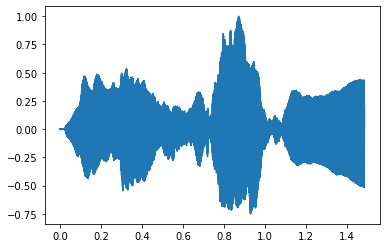

In [38]:
violin.truncate(2**16)
violin.plot()

Теперь мы можем сравнить с `np.convolve`:

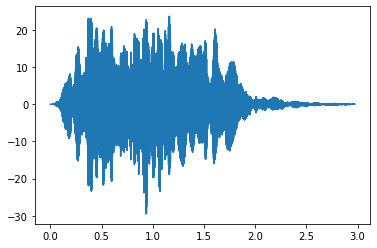

In [39]:
output2 = violin.convolve(response)
output2.plot()

Результаты максимально похожи.

In [40]:
output2.make_audio()

Звук такой же, но длина не та.

In [41]:
len(output), len(output2)

(131072, 131071)

`scipy.signal.fftconvolve` делает то же самое, но, как следует из названия, он использует ДПФ, поэтому он значительно быстрее:

In [42]:
import scipy.signal
ys = scipy.signal.fftconvolve(violin.ys, response.ys)
output3 = thinkdsp.Wave(ys, framerate=violin.framerate)

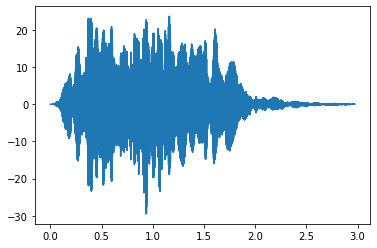

In [43]:
output3.plot()

In [44]:
output3.make_audio()

Результат тот же. В пределах ошибки с плавающей запятой результаты такие же:

In [45]:
output2.max_diff(output3)

2.1316282072803006e-14

### Упражнение 10.2

Звук взят отсюда:

https://www.openair.hosted.york.ac.uk/?page_id=406

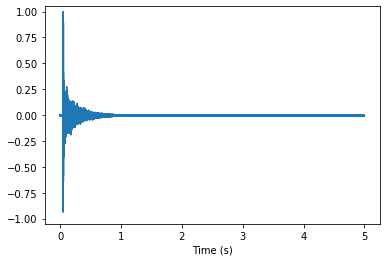

In [49]:
response = thinkdsp.read_wave('mono_s1r1.wav')

start = 0
duration = 5
response = response.segment(duration=duration)
response.shift(-start)

response.normalize()
response.plot()
thinkplot.config(xlabel='Time (s)', ylim=[-1.05, 1.05])

Прослушаем звук.

In [50]:
response.make_audio()

ДПФ импульсной характеристики - это передаточная функция:

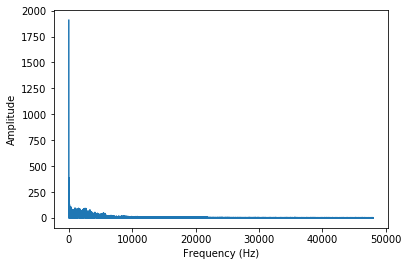

In [51]:
transfer = response.make_spectrum()
transfer.plot()
thinkplot.config(xlabel='Frequency (Hz)', ylabel='Amplitude')

Рассмотрим передаточную функцию в логарифмическом масштабе:

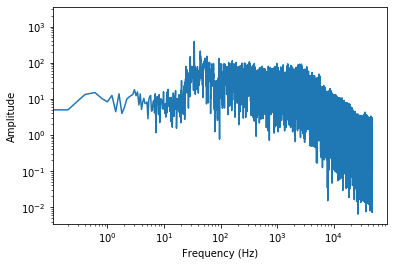

In [52]:
transfer.plot()
thinkplot.config(xlabel='Frequency (Hz)', ylabel='Amplitude',
                 xscale='log', yscale='log')

Теперь мы можем смоделировать звучание записи, если бы её воспроизвели в одной комнате и записали бы таким же образом. 

Запись нам нужна той же частоты дискретизации, что и предыдущая, поэтому пришлось искать в интернете запись с 96 kHz. Запись можно скачать по ссылке: https://freesound.org/people/shakaharu/sounds/88498/

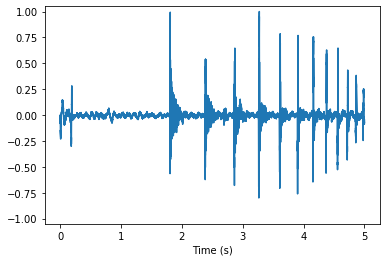

In [55]:
wave = thinkdsp.read_wave('88498__shakaharu__ball-basketball-drop.wav')

start = 0.0
wave = wave.segment(start=start)
wave.shift(-start)

wave.truncate(len(response))
wave.normalize()
wave.plot()
thinkplot.config(xlabel='Time (s)', ylim=[-1.05, 1.05])

Проверим частоту дискретизации.

In [32]:
#!pip install pydub
from pydub import AudioSegment
song = AudioSegment.from_mp3("mono_s1r1.wav")
song.frame_rate

96000

In [56]:
song2 = AudioSegment.from_mp3("88498__shakaharu__ball-basketball-drop.wav")
song2.frame_rate

96000

Вот как это звучит до трансформации:

In [57]:
wave.make_audio()

Теперь мы вычисляем ДПФ записи скачущего баскетбольного мяча.

In [58]:
spectrum = wave.make_spectrum()

Обрежем запись скрипки до той же длины, что и импульсная характеристика:

In [59]:
len(spectrum.hs), len(transfer.hs)

(240001, 240001)

In [60]:
spectrum.fs

array([    0. ,     0.2,     0.4, ..., 47999.6, 47999.8, 48000. ])

In [61]:
transfer.fs

array([    0. ,     0.2,     0.4, ..., 47999.6, 47999.8, 48000. ])

Мы можем умножить в частотной области и преобразовать обратно во временную область.

In [62]:
output = (spectrum * transfer).make_wave()
output.normalize()

Рассмотрим сравнение оригинальной и преобразованной записи:

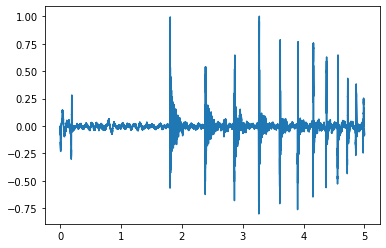

In [63]:
wave.plot()

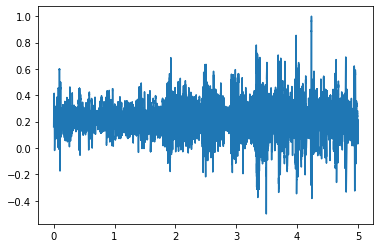

In [64]:
output.plot()

А вот как это звучит:

In [65]:
output.make_audio()

Теперь, когда мы распознаем эту операцию как свёртку, мы можем вычислить ее с помощью метода `convolve`:

In [66]:
convolved2 = wave.convolve(response)
convolved2.normalize()
convolved2.make_audio()